In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
!pip install lightgbm pandas numpy scikit-learn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping
from scipy import stats
from scipy.stats import norm

In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
#ID列を別のデータに保管
train_ID = train['Id']
test_ID = test['Id']
#学習データとテストデータからId列を削除
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)
#学習データとテストデータの形式を確認
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


In [4]:
#予測するSalePriceの情報を確認
print(train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [5]:
#SalePriceに欠損値がないか確認
train['SalePrice'].isnull().sum()

0

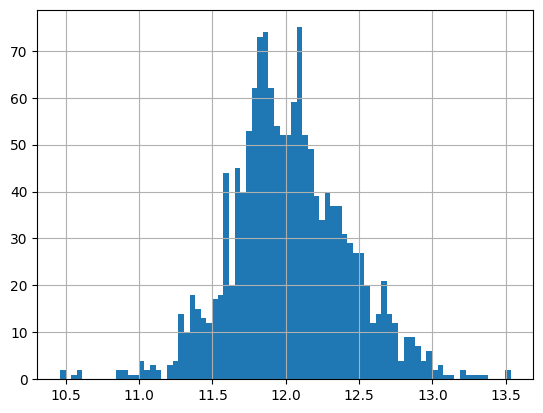

In [6]:
#SalePriceのヒストグラムの記載と対数変換
np.log1p(train['SalePrice']).hist(bins=80)
train['SalePrice'] = np.log1p(train['SalePrice'])

<function matplotlib.pyplot.show(close=None, block=None)>

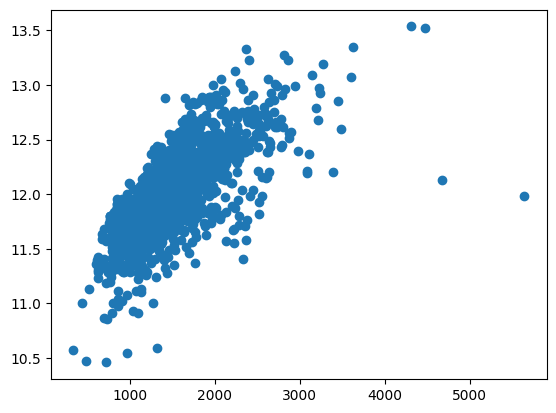

In [7]:
#GrLivAreaとSalePriceの散布図を作成
plt.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.show

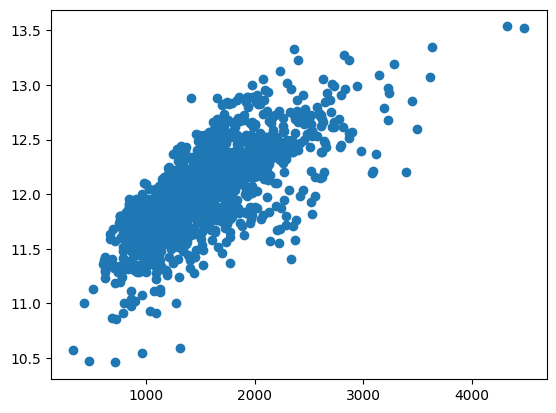

In [8]:
#外れ値の削除
train=train.drop(train[(train['SalePrice'] <= 12.5) & (train['GrLivArea'] >= 4000)].index)
#グラフを再表示
plt.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.show
train_y = train['SalePrice']

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


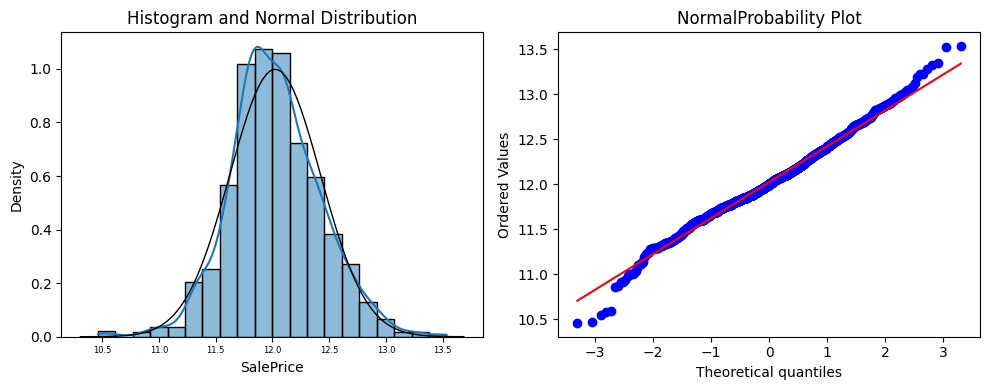

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

#ヒストグラムと正規分布を表示するサブプロット
sns.histplot(train_y, stat='density',kde=True,bins=20,ax=ax[0])
ax[0].set_title('Histogram and Normal Distribution')
#x軸のラベルの文字サイズを調整
ax[0].tick_params(axis='x', labelsize=6)

xmin, xmax = ax[0].get_xlim()
x = np.linspace(xmin,xmax,100)
p = norm.pdf(x, np.mean(train_y),np.std(train_y))
ax[0].plot(x, p, 'k',linewidth=1)

#正規確率プロットを表示するサブプロット
res = stats.probplot(train_y,plot=ax[1])
ax[1].set_title('NormalProbability Plot')

#グラフのレイアウトの調整
plt.tight_layout()

In [10]:
#学習データとテストデータの結合
ntrain = train.shape[0]
ntest = test.shape[0]
train_test_add_data = pd.concat([train,test],axis=0).reset_index(drop=True)
train_test_add_data.drop(['SalePrice'], axis=1, inplace=True)
#結合データの確認
print(train_test_add_data.shape)                                

(2917, 79)


In [11]:
train_test_add_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   int64  
 1   MSZoning       2913 non-null   object 
 2   LotFrontage    2431 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2917 non-null   object 
 7   LandContour    2917 non-null   object 
 8   Utilities      2915 non-null   object 
 9   LotConfig      2917 non-null   object 
 10  LandSlope      2917 non-null   object 
 11  Neighborhood   2917 non-null   object 
 12  Condition1     2917 non-null   object 
 13  Condition2     2917 non-null   object 
 14  BldgType       2917 non-null   object 
 15  HouseStyle     2917 non-null   object 
 16  OverallQual    2917 non-null   int64  
 17  OverallCond    2917 non-null   int64  
 18  YearBuil

In [12]:
#欠損値の補完
train_test_add_data['MSZoning'] = train_test_add_data['MSZoning'].fillna(train_test_add_data['MSZoning'].mode()[0])
train_test_add_data['LotFrontage']=train_test_add_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train_test_add_data['Alley'] = train_test_add_data['Alley'].fillna("Missing")
train_test_add_data['Utilities'] = train_test_add_data['Utilities'].fillna(train_test_add_data['Utilities'].mode()[0])
train_test_add_data['Exterior1st'] = train_test_add_data['Exterior1st'].fillna(train_test_add_data['Exterior1st'].mode()[0])
train_test_add_data['Exterior2nd'] = train_test_add_data['Exterior2nd'].fillna(train_test_add_data['Exterior2nd'].mode()[0])
train_test_add_data['MasVnrType'] = train_test_add_data['MasVnrType'].fillna("Missing")
train_test_add_data['MasVnrArea'] = train_test_add_data['MasVnrArea'].fillna(train_test_add_data['MasVnrArea'].median())
train_test_add_data['KitchenQual'] = train_test_add_data['KitchenQual'].fillna(train_test_add_data['KitchenQual'].mode()[0])
train_test_add_data['Functional'] = train_test_add_data['Functional'].fillna(train_test_add_data['Functional'].mode()[0])
train_test_add_data['FireplaceQu'] = train_test_add_data['FireplaceQu'].fillna("Missing")
train_test_add_data['GarageCars'] = train_test_add_data['GarageCars'].fillna(0)
train_test_add_data['GarageArea'] = train_test_add_data['GarageArea'].fillna(0)
train_test_add_data['GarageYrBlt'] = train_test_add_data['GarageYrBlt'].fillna(0)
train_test_add_data['Fence'] = train_test_add_data['Fence'].fillna("Missing")
train_test_add_data['MiscFeature'] = train_test_add_data['MiscFeature'].fillna("Missing")
train_test_add_data['SaleType'] = train_test_add_data['SaleType'].fillna(train_test_add_data['SaleType'].mode()[0])
train_test_add_data['Electrical'] = train_test_add_data['Electrical'].fillna(train_test_add_data['Electrical'].mode()[0])
train_test_add_data['PoolQC'] = train_test_add_data['PoolQC'].fillna("Missing")

In [13]:
#欠損値の補完
for col in('BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'):
    train_test_add_data[col]=train_test_add_data[col].fillna("Missing")

for col in('BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath'):
    train_test_add_data[col]=train_test_add_data[col].fillna(0)

for col in('GarageType','GarageFinish','GarageQual','GarageCond'):
    train_test_add_data[col]=train_test_add_data[col].fillna("Missing")

In [14]:
#順序や記号を表す数値データを文字列データに変換
train_test_add_data['MSSubClass']=train_test_add_data['MSSubClass'].astype(str)

In [15]:
train_test_add_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   object 
 1   MSZoning       2917 non-null   object 
 2   LotFrontage    2917 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   Alley          2917 non-null   object 
 6   LotShape       2917 non-null   object 
 7   LandContour    2917 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2917 non-null   object 
 10  LandSlope      2917 non-null   object 
 11  Neighborhood   2917 non-null   object 
 12  Condition1     2917 non-null   object 
 13  Condition2     2917 non-null   object 
 14  BldgType       2917 non-null   object 
 15  HouseStyle     2917 non-null   object 
 16  OverallQual    2917 non-null   int64  
 17  OverallCond    2917 non-null   int64  
 18  YearBuil

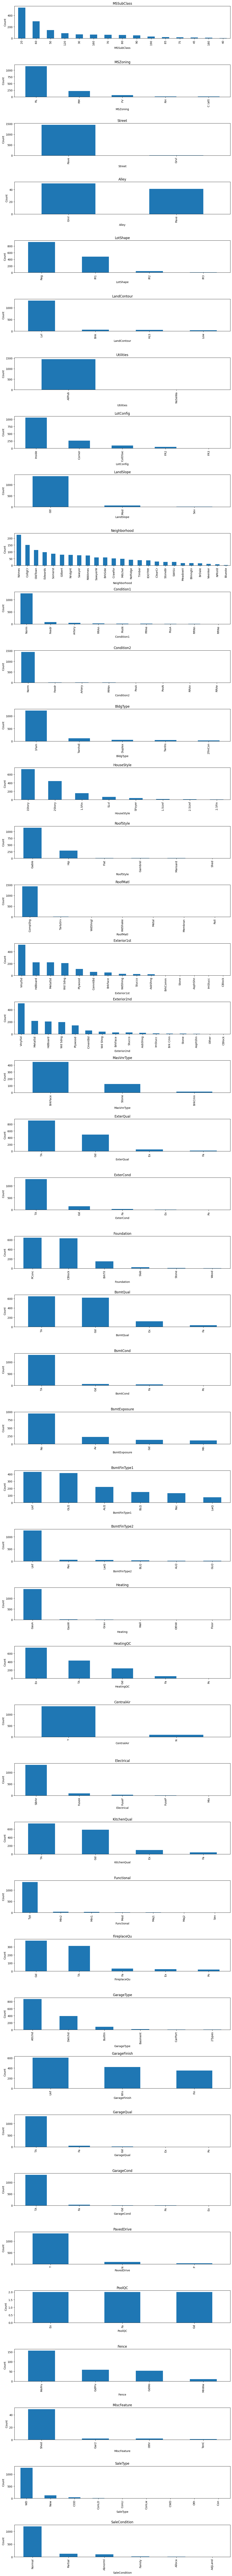

In [16]:
#棒グラフの作成
# object型の列を抽出
object_columns = train_test_add_data.select_dtypes(include='object').columns

# object型の列が存在するか確認
if len(object_columns) > 0:
    # グラフのサイズを設定
    num_columns = len(object_columns)
    height_per_plot = 3
    figsize = (12, num_columns * height_per_plot)
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=figsize)

    # object型の各列の値をプロット
    for i, col in enumerate(object_columns):
        train[col].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_ylabel('Count')
        axes[i].set_title(col)

    # レイアウト調整
    plt.tight_layout()
    plt.show()
else:
    print("データフレームにobject型の列が存在しません。")

Street
Pave    1452
Grvl       6
Name: count, dtype: int64
Street
Pave    1453
Grvl       6
Name: count, dtype: int64


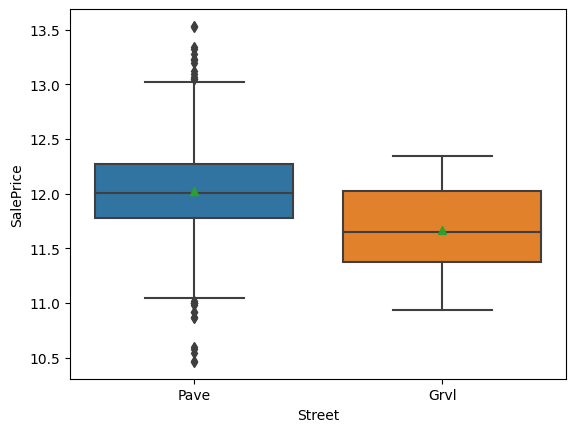

In [17]:
#Streetに関して確認
print(train['Street'].value_counts())
print(test['Street'].value_counts())
sns.boxplot(x='Street', y=train_y, data=train,showmeans=True)
plt.show()

Utilities
AllPub    1457
NoSeWa       1
Name: count, dtype: int64
Utilities
AllPub    1457
Name: count, dtype: int64


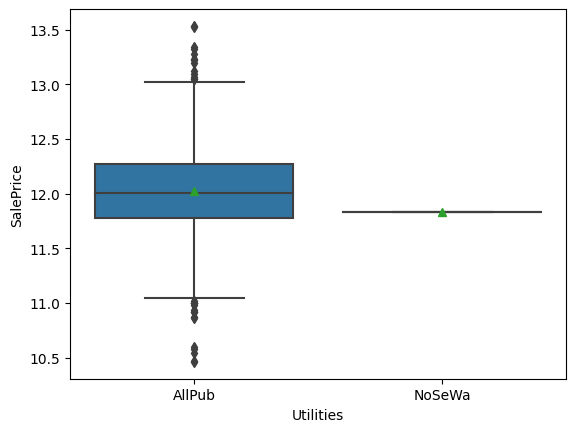

In [18]:
#Utilitiesに関して確認
print(train['Utilities'].value_counts())
print(test['Utilities'].value_counts())
sns.boxplot(x='Utilities', y=train_y, data=train,showmeans=True)
plt.show()

LandSlope
Gtl    1380
Mod      65
Sev      13
Name: count, dtype: int64
LandSlope
Gtl    1396
Mod      60
Sev       3
Name: count, dtype: int64


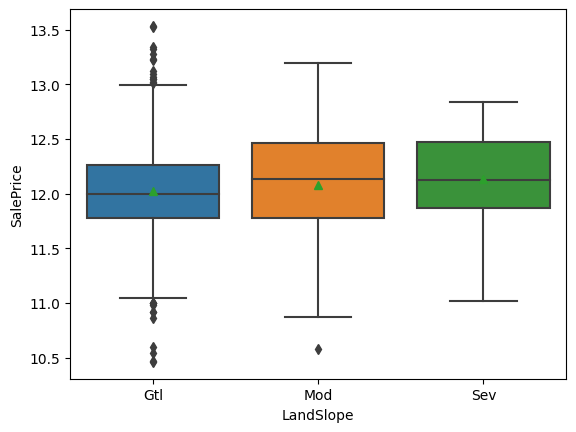

In [19]:
#LandSlopeに関して確認
print(train['LandSlope'].value_counts())
print(test['LandSlope'].value_counts())
sns.boxplot(x='LandSlope', y=train_y, data=train,showmeans=True)
plt.show()

Condition2
Norm      1444
Feedr        6
Artery       2
RRNn         2
PosA         1
PosN         1
RRAn         1
RRAe         1
Name: count, dtype: int64
Condition2
Norm      1444
Feedr        7
PosA         3
Artery       3
PosN         2
Name: count, dtype: int64


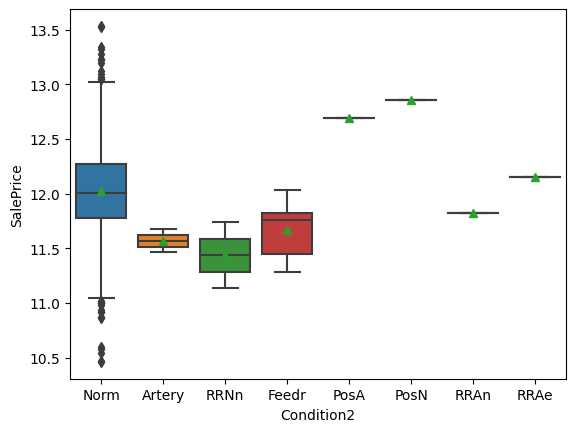

In [20]:
#Condition2に関して確認
print(train['Condition2'].value_counts())
print(test['Condition2'].value_counts())
sns.boxplot(x='Condition2', y=train_y, data=train,showmeans=True)
plt.show()

RoofMatl
CompShg    1433
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
Name: count, dtype: int64
RoofMatl
CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: count, dtype: int64


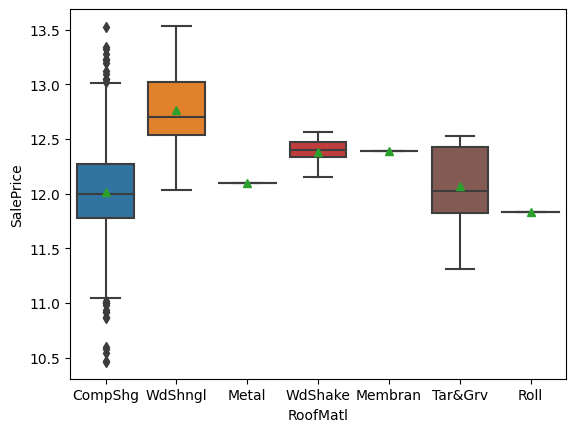

In [21]:
#RoofMatlに関して確認
print(train['RoofMatl'].value_counts())
print(test['RoofMatl'].value_counts())
sns.boxplot(x='RoofMatl', y=train_y, data=train,showmeans=True)
plt.show()

Heating
GasA     1426
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: count, dtype: int64
Heating
GasA    1446
GasW       9
Grav       2
Wall       2
Name: count, dtype: int64


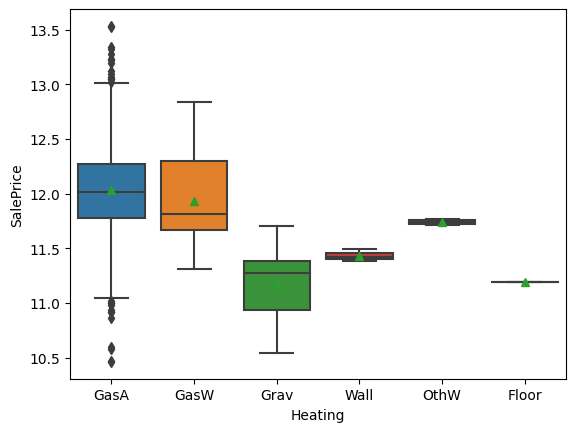

In [22]:
#Heatingに関して確認
print(train['Heating'].value_counts())
print(test['Heating'].value_counts())
sns.boxplot(x='Heating', y=train_y, data=train,showmeans=True)
plt.show()

In [23]:
#結合データから数値データのみを除去
train_test_add_object = train_test_add_data.select_dtypes(exclude=['int64','float64'])
train_test_add_object.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [24]:
#Label Encodingするカラムのみ抽出
label_encoding_columns = train_test_add_data[['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType','Foundation','Heating',
       'CentralAir', 'Electrical','Functional','GarageType','PavedDrive',
       'Fence', 'MiscFeature','SaleType','SaleCondition']]

In [25]:
#特定のobjectデータをLabel Encoding
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in label_encoding_columns.columns:
    le = LabelEncoder()
    train_test_add_data[col] = le.fit_transform(train_test_add_data[col])
    label_encoders[col] = le

In [26]:
#Ordinal Encodingするカラムのみ抽出
ordinal_encoding_columns = [['ExterQual','ExterCond','BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1',
'BsmtFinType2','HeatingQC', 'KitchenQual','FireplaceQu','GarageFinish','GarageQual', 'GarageCond','PoolQC']]

In [27]:
#特定のobjectデータをOrdinal Encoding
from sklearn.preprocessing import OrdinalEncoder

ordinal_columns = ordinal_encoding_columns[0]

#順序を定義
Qual_order = ['Missing','Po','Fa','TA','Gd','Ex']
Exposure_order = ['Missing','No','Mn','Av','Gd']
Bsmt_Fin_order = ['Missing','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
Garage_Fin_order = ['Missing','Unf','RFn','Fin']


#各カラムの順序を設定する辞書
ordinal_mappings = {
    'ExterQual':Qual_order,
    'ExterCond':Qual_order,
    'BsmtQual':Qual_order,
    'BsmtCond':Qual_order,
    'BsmtExposure':Exposure_order,
    'BsmtFinType1':Bsmt_Fin_order,
    'BsmtFinType2':Bsmt_Fin_order,
    'HeatingQC':Qual_order,
    'KitchenQual':Qual_order,
    'FireplaceQu':Qual_order,
    'GarageFinish':Garage_Fin_order,
    'GarageQual':Qual_order,
    'GarageCond':Qual_order,
    'PoolQC':Qual_order,
}

encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_columns])
train_test_add_data[ordinal_columns] = encoder.fit_transform(train_test_add_data[ordinal_columns])


In [28]:
#Street,Utilities,LandSlopeを削除
train_test_add_data_drop = train_test_add_data.drop(['Street','Utilities','LandSlope'],axis=1)

In [29]:
train = train_test_add_data_drop[:ntrain]
test = train_test_add_data_drop[ntrain:]

In [30]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
predictions_array=[]
CV_score_array=[]

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1
}

for train_index, test_index in kf.split(train):
    x_train, x_valid = train.iloc[train_index], train.iloc[test_index]
    y_train, y_valid = train_y.iloc[train_index],train_y.iloc[test_index]
    
    regressor = LGBMRegressor(**params)

    callbacks = [early_stopping(stopping_rounds=100, verbose=True)]
    
    regressor.fit(
    x_train,y_train,
    eval_set= [(x_valid, y_valid)],
    eval_metric="rmse",
    callbacks=callbacks
    )

    best_iteration = regressor.best_iteration_
    valid_predictions = regressor.predict(x_valid, num_iteration=best_iteration)
    
    rmse = np.sqrt(np.mean((y_valid - valid_predictions)** 2))
    CV_score_array.append(rmse)

    valid_predictions = regressor.predict(test, num_iteration=best_iteration)
    predictions_array.append(np.expm1(valid_predictions))

average_cv_rmse = np.mean(CV_score_array)
average_pr_rmse = np.mean(predictions_array)

print(f"Average CV RMSE: {average_cv_rmse:.4f}")
print(f"Average PR RMSE: {average_pr_rmse:.4f}")

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.133955
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's rmse: 0.121412
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's rmse: 0.137082
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.131977
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.11366
Average CV RMSE: 0.1276
Average PR RMSE: 177752.3806


In [31]:
tmp = pd.DataFrame(predictions_array).T
tmp['average'] = tmp.mean(axis=1)
tmp

,0,1,2,3,4,average
0,125065.060754,124044.876998,127491.549965,126195.817205,126969.610541,125953.383093
1,157675.358334,157028.897727,154117.745407,153090.704450,164693.164603,157321.174104
2,191103.063501,182440.590517,187407.498980,173065.617750,192931.223044,185389.598759
3,188531.940834,187529.552340,190636.771362,185381.757672,184051.535930,187226.311628
4,194510.904085,188711.275179,182181.691116,187089.207442,185269.152434,187552.446051
...,...,...,...,...,...,...
1454,77011.155937,82770.988783,75684.411179,77709.375061,78671.337275,78369.453647
1455,89603.364520,80527.563999,75275.032049,88250.197211,79863.184627,82703.868481
1456,152847.975671,147320.818207,157059.748420,157708.778493,163184.490981,155624.362354
1457,117333.748853,111835.251038,110412.533311,116842.887366,121019.544850,115488.793084


In [32]:
submission = pd.DataFrame({'Id':test_ID, 'SalePrice':tmp['average']})
submission.to_csv('submission_DecisionTreeClassifier_5.csv', index=False)